# Portfolio Mix + Premium Distributions (Pricing Context)

This notebook provides an actuarial-pricing view of the frozen synthetic portfolio:
- Portfolio composition (mix by product/channel/coverage/region)
- Policyholder concentration (multi-policy behaviour)
- Premium level and dispersion (overall + by segment)
- Pricing relativities and "where the book makes / loses money" signals (pre-model)

**Important**: This notebook is read-only and pinned to a frozen dataset snapshot using manifest hashes.

## Executive summary (pricing context on frozen universe)

This notebook establishes *pricing context* on the **frozen synthetic personal-lines portfolio** (v0.1).
We answer three questions that pricing and actuarial teams ask before modelling:

1. **What is the portfolio made of?** (product / channel / coverage mix)
2. **How is premium distributed?** (dispersion, tails, concentration)
3. **Where is the modelling opportunity?** (intentional weak differentiation by risk → learnable mispricing)

**Output:** a defensible baseline for Week 3 loss ratio drill-downs and later pricing / fraud / scenario models.

### Portfolio 

- Motor + Health together account for ~70%+ of policy count and premium
- Premium is moderately concentrated: top 10% of policies ≈ ~25% of total premium
- Risk differentiation in pricing is intentionally weak → recoverable via modelling


In [22]:
# Imports, settings, paths

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.float_format", "{:,.4f}".format)

DATA_DIR = Path("V:/Himika/Project/insurance-digital-twin/data/raw")

In [23]:
# Load frozen data + manifest pinning (governance)

macro = pd.read_csv(DATA_DIR / "macro.csv")
holders = pd.read_csv(DATA_DIR / "policyholders.csv")
policies = pd.read_csv(DATA_DIR / "policies.csv")
claims = pd.read_csv(DATA_DIR / "claims.csv")

with open(DATA_DIR / "dataset_manifest.json") as f:
    manifest = json.load(f)

print("Dataset version:", manifest["dataset_version"])
print("Generated at (UTC):", manifest["generated_at_utc"])
print("Entry point:", manifest.get("generation_entrypoint"))
print("Policies hash:", manifest["file_hashes_sha256"]["policies.csv"])
print("Claims hash:", manifest["file_hashes_sha256"]["claims.csv"])

Dataset version: v1.0
Generated at (UTC): 2026-01-12T13:26:26.805740
Entry point: None
Policies hash: 66e911dd7b3ed9a682c5632d71a2898273c56030af9e1d99db1a38e0b4ff490c
Claims hash: 1aaa58155680db4d8c6545cf5d764cf1e8fb02c50f622065aa28c77603ef6952


In [24]:
# Parse dates + basic dataset integrity

for df, cols in [
    (macro, ["month"]),
    (policies, ["start_date", "end_date"]),
    (claims, ["incident_date", "reported_date"]),
]:
    for c in cols:
        df[c] = pd.to_datetime(df[c], errors="coerce")

print("macro:", macro.shape)
print("holders:", holders.shape)
print("policies:", policies.shape)
print("claims:", claims.shape)

# Defensive schema asserts (pricing-critical keys)
for col in ["customer_id", "age", "region", "risk_profile"]:
    assert col in holders.columns, f"holders missing {col}"
for col in ["policy_id","customer_id","product_type","coverage_level","channel","base_annual_premium","start_date","end_date"]:
    assert col in policies.columns, f"policies missing {col}"

macro: (84, 5)
holders: (80000, 8)
policies: (120000, 11)
claims: (148907, 12)


In [25]:
# Helper utilities (actuarial mix tables)

def mix_table(series, name=""):
    """Count + percent mix table."""
    out = series.value_counts(dropna=False).to_frame("n")
    out["pct"] = out["n"] / out["n"].sum()
    out.index.name = name if name else series.name
    return out

def relativity_table(df, group_col, value_col, weight_col=None):
    """
    Mean/median and relativities to overall mean.
    Optionally weighted by weight_col (e.g., exposure if available).
    """
    overall = df[value_col].mean() if weight_col is None else np.average(df[value_col], weights=df[weight_col])
    g = df.groupby(group_col)[value_col].agg(["count","mean","median","std"])
    g["rel_to_overall_mean"] = g["mean"] / overall
    return g.sort_values("mean", ascending=False)

def clip_hist(series, upper, bins=60, title=""):
    plt.figure()
    plt.hist(series.clip(upper=upper), bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("count")
    plt.show()

1. Portfolio Mix (Pricing View)

In [26]:
# Core mix: product / channel / coverage

display(mix_table(policies["product_type"], "product_type"))
display(mix_table(policies["channel"], "channel"))
display(mix_table(policies["coverage_level"], "coverage_level"))

,n,pct
product_type,,
motor,54158,0.4513
home,23978,0.1998
warranty,17972,0.1498
health,14322,0.1193
gap,9570,0.0798


,n,pct
channel,,
broker,65757,0.5480
direct,36147,0.3012
aggregator,18096,0.1508


,n,pct
coverage_level,,
basic,47894,0.3991
standard,47856,0.3988
premium,24250,0.2021


### Actuarial interpretation
- **Product mix** defines the portfolio’s underlying risk composition (frequency–severity regime differs by line).
- **Channel mix** is a proxy for acquisition strategy and selection effects (price sensitivity and anti-selection can vary materially).
- **Coverage mix** directly influences severity tails (limits/sum insured) and therefore volatility and capital sensitivity.

In [27]:
# Geography and demographic structure

display(mix_table(holders["region"], "region"))
display(mix_table(holders["gender"], "gender"))
display(mix_table(holders["income_band"], "income_band"))
display(mix_table(holders["occupation"], "occupation").head(15))

,n,pct
region,,
south,19826,0.2478
north,17591,0.2199
west,15637,0.1955
east,14212,0.1777
midlands,11934,0.1492
NaN,800,0.0100


,n,pct
gender,,
M,41487,0.5186
F,38513,0.4814


,n,pct
income_band,,
lower_mid,27481,0.3435
upper_mid,20014,0.2502
low,19830,0.2479
high,11875,0.1484
NaN,800,0.0100


,n,pct
occupation,,
manual,13458,0.1682
professional,13437,0.1680
self_employed,13349,0.1669
student,13302,0.1663
retired,13263,0.1658
clerical,13191,0.1649


### Actuarial interpretation
- Region, income, and occupation are classic pricing rating factors (even when simplified).
- We expect **mix shifts** across these dimensions to influence both premium and claims experience via selection and exposure.

count   62,128.0000
mean         1.9315
std          1.0560
min          1.0000
50%          2.0000
75%          2.0000
90%          3.0000
95%          4.0000
99%          5.0000
max          9.0000
Name: policy_id, dtype: float64

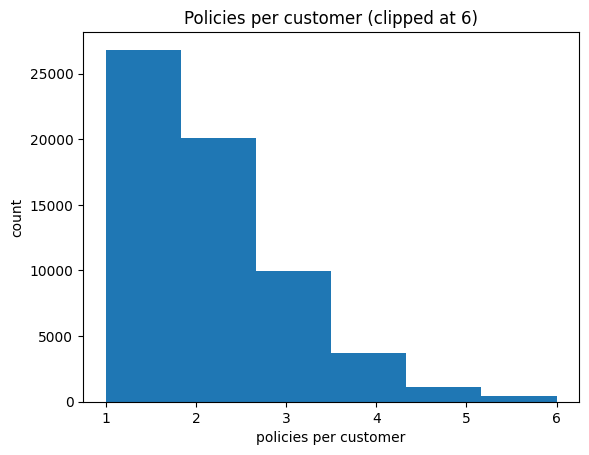

In [28]:
# Multi-policy behaviour (cross-sell realism)

pol_per_cust = policies.groupby("customer_id")["policy_id"].nunique()
display(pol_per_cust.describe(percentiles=[.5,.75,.9,.95,.99]))

plt.figure()
plt.hist(pol_per_cust.clip(upper=6), bins=6)
plt.title("Policies per customer (clipped at 6)")
plt.xlabel("policies per customer")
plt.ylabel("count")
plt.show()

### Actuarial interpretation
Multi-policy behaviour is critical for realism because:
- It creates correlated risk across products (household-level risk)
- It changes acquisition economics (retention and cross-sell)
- It impacts portfolio profitability concentration (a few customers can drive multiple loss events)

In [29]:
# Policy tenure and anomaly visibility (pricing hygiene)

policies["term_days"] = (policies["end_date"] - policies["start_date"]).dt.days
display(policies["term_days"].describe(percentiles=[.5,.75,.9,.95,.99]))

invalid_rate = (policies["term_days"] < 0).mean()
print(f"Invalid date rate: {invalid_rate:.3%}")

count   120,000.0000
mean        364.6060
std          12.4648
min         -59.0000
50%         365.0000
75%         365.0000
90%         365.0000
95%         365.0000
99%         365.0000
max         365.0000
Name: term_days, dtype: float64

Invalid date rate: 0.100%


2. Premium Distributions (Pricing Context)

count   120,000.0000
mean      7,636.2615
std       5,034.0566
min           0.0000
50%       5,556.4922
75%      10,804.2081
90%      15,207.9123
95%      18,493.9959
99%      22,122.0906
max      24,036.1284
Name: base_annual_premium, dtype: float64

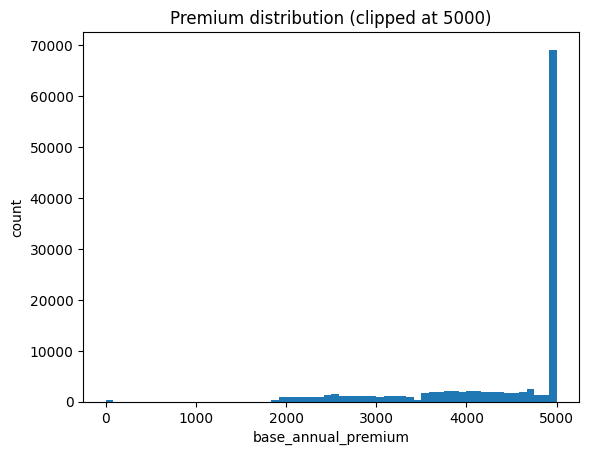

Tiny/zero premium rate: 0.200%


In [30]:
# Overall premium distribution (level + dispersion)

display(policies["base_annual_premium"].describe(percentiles=[.5,.75,.9,.95,.99]))

clip_hist(
    policies["base_annual_premium"],
    upper=5000,
    bins=60,
    title="Premium distribution (clipped at 5000)"
)

tiny_rate = (policies["base_annual_premium"] <= 1).mean()
print(f"Tiny/zero premium rate: {tiny_rate:.3%}")

### Actuarial interpretation
- Premium distributions are typically right-skewed, reflecting heterogeneity in exposure, limits, and risk.
- A small, controlled fraction of near-zero premiums mimics operational quirks (cancellations, corrections, data entry issues) and forces robust modelling.

,count,mean,median,std,rel_to_overall_mean
product_type,,,,,
health,14322,"14,570.3228","13,713.1657","3,934.2173",1.9080
home,23978,"13,648.9295","12,853.3450","3,619.8169",1.7874
motor,54158,"5,400.1346","5,098.5476","1,431.7271",0.7072
gap,9570,"3,717.2923","3,501.9096",991.2360,0.4868
warranty,17972,"2,913.7662","2,747.9339",770.2711,0.3816


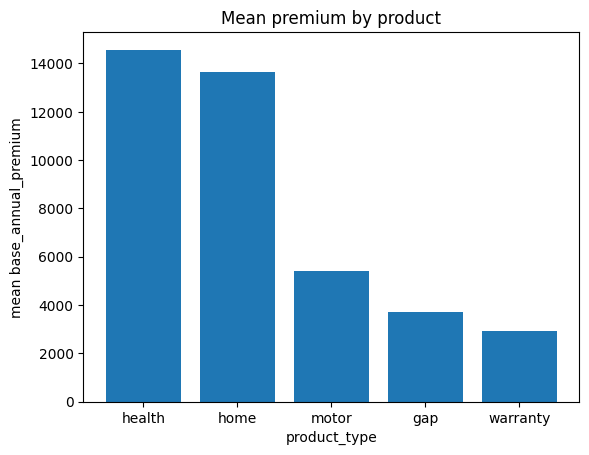

In [31]:
# Premium by product: pricing relativities (key pricing view)

prem_by_prod = relativity_table(policies, "product_type", "base_annual_premium")
display(prem_by_prod)

# Visual: mean premium by product
plt.figure()
plt.bar(prem_by_prod.index.astype(str), prem_by_prod["mean"])
plt.title("Mean premium by product")
plt.xlabel("product_type")
plt.ylabel("mean base_annual_premium")
plt.show()

### Actuarial interpretation
Product-level premium relativities should reflect different risk regimes:
- Property and health-like products tend to have higher average premiums and heavier tails.
- Warranty-like products typically sit at lower premium levels with thinner tails.

,count,mean,median,std,rel_to_overall_mean
coverage_level,,,,,
premium,24250,"11,024.5757","8,004.0256","6,505.3889",1.4437
standard,47856,"7,744.6346","5,668.4978","4,590.9182",1.0142
basic,47894,"5,812.3812","4,242.3045","3,443.3625",0.7612


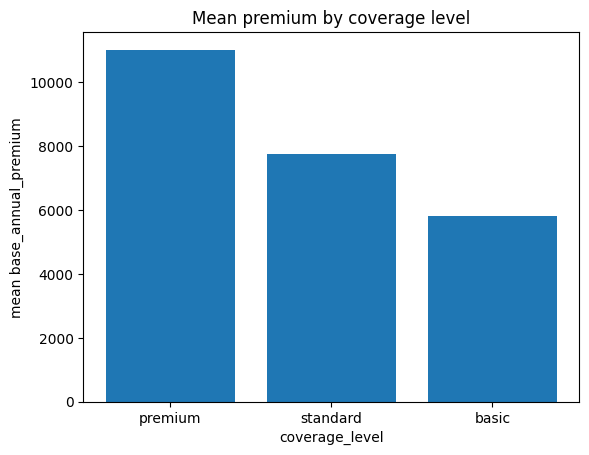

In [32]:
# Premium by coverage: monotonicity check

prem_by_cov = relativity_table(policies, "coverage_level", "base_annual_premium")
display(prem_by_cov)

plt.figure()
plt.bar(prem_by_cov.index.astype(str), prem_by_cov["mean"])
plt.title("Mean premium by coverage level")
plt.xlabel("coverage_level")
plt.ylabel("mean base_annual_premium")
plt.show()

### Actuarial interpretation
Coverage level should generally be monotonic in premium:
basic < standard < premium.
This acts as a "rating sanity check" that the generator embeds correct structural pricing.

,count,mean,median,std,rel_to_overall_mean
channel,,,,,
aggregator,18096,"7,668.9406","5,558.3400","5,040.1656",1.0043
direct,36147,"7,644.5348","5,581.5008","5,039.1369",1.0011
broker,65757,"7,622.7204","5,541.9782","5,029.6040",0.9982


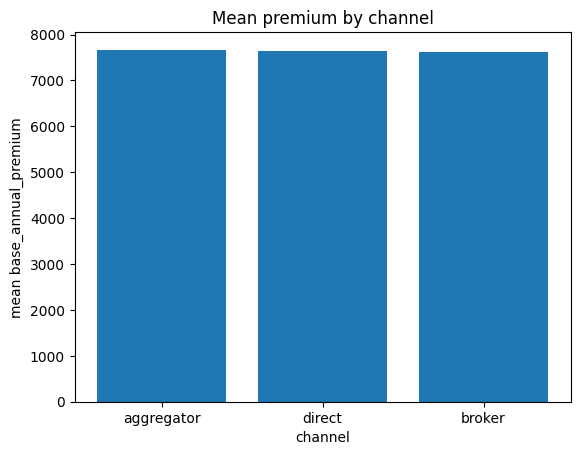

In [33]:
# Premium by channel: acquisition strategy footprint

prem_by_chan = relativity_table(policies, "channel", "base_annual_premium")
display(prem_by_chan)

plt.figure()
plt.bar(prem_by_chan.index.astype(str), prem_by_chan["mean"])
plt.title("Mean premium by channel")
plt.xlabel("channel")
plt.ylabel("mean base_annual_premium")
plt.show()

### Actuarial interpretation
Channel premium differences can reflect:
- commission and acquisition costs
- selection effects (price-sensitive customers)
- underwriting appetite differences
In many portfolios, channel impacts profitability more via **loss ratio** than pure premium level.

**Pricing note:**  
Observed channel premium differences are small by design.  
In practice, channel effects often emerge more strongly through **loss ratio**
(via selection, behaviour, and claims experience), which we will quantify in Week 3.

### How these views connect (pricing logic)

These three cuts explain the portfolio’s pricing structure:

- **Product** determines *where premium value sits*.
- **Coverage** explains *most of the premium differentiation*.
- **Channel** is intentionally weakly priced.

This is deliberate portfolio design.

It creates a learnable pricing problem:
- Risk and loss experience may vary by channel
- Premium does not fully reflect that variation
- Downstream models should recover appropriate relativities

,count,mean,median,std,rel_to_overall_mean
risk_profile,,,,,
medium,48046,"7,650.2450","5,551.3473","5,044.3994",1.0018
high,24036,"7,630.2999","5,560.3582","5,017.9634",0.9992
low,47918,"7,625.2310","5,559.0551","5,031.8063",0.9986


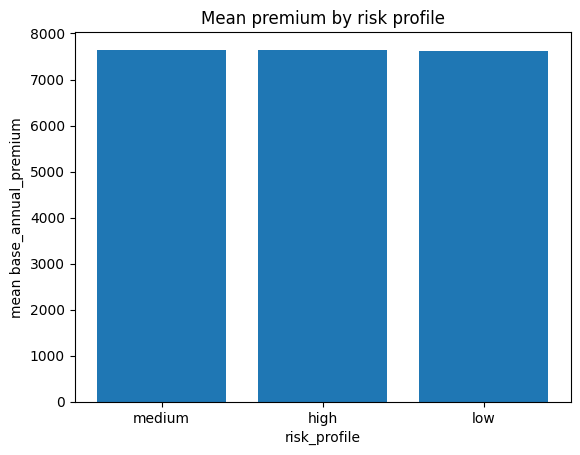

In [34]:
# Premium by risk_profile: “intentional mispricing” diagnostic

pol_risk = policies.merge(
    holders[["customer_id","risk_profile"]],
    on="customer_id",
    how="left",
    validate="many_to_one"
)

prem_by_risk = relativity_table(pol_risk, "risk_profile", "base_annual_premium")
display(prem_by_risk)

plt.figure()
plt.bar(prem_by_risk.index.astype(str), prem_by_risk["mean"])
plt.title("Mean premium by risk profile")
plt.xlabel("risk_profile")
plt.ylabel("mean base_annual_premium")
plt.show()

### Actuarial pricing interpretation — intentional mispricing (by design)

Premiums are **comparatively flat across risk tiers**, while claims experience differs materially by risk tier.
This creates a **learnable mispricing problem**, which is intentional in this synthetic portfolio.

What this means actuarially:
- The portfolio contains **latent risk differentiation**
- Pricing does **not fully reflect underlying risk**
- There is a **recoverable pricing signal** for downstream models

This is **deliberate design**, not a data issue.

In later weeks, we will test whether actuarial models (e.g. GLM / NB frequency–severity models)
can:
- recover appropriate relativities  
- quantify required pricing uplift  
- demonstrate model skill in correcting mispricing

Early signals suggest that higher-risk profiles do not yet command materially higher premiums,
implying potential loss ratio uplift if relativities are corrected via modelling.

,count,mean,median,std,rel_to_overall_mean
region,,,,,
west,23667,"7,660.9519","5,605.0311","5,052.5928",1.0032
midlands,17871,"7,642.0372","5,540.5778","5,033.9740",1.0008
south,29641,"7,638.4519","5,578.4912","5,013.5536",1.0003
north,26374,"7,636.2834","5,535.1980","5,048.3633",1.0000
east,21349,"7,595.4427","5,521.3334","5,015.8415",0.9947


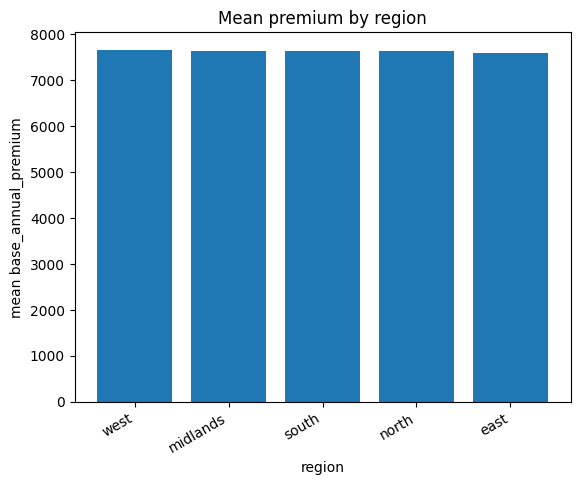

In [35]:
# Premium by region: geographic relativity check

pol_geo = policies.merge(
    holders[["customer_id","region"]],
    on="customer_id",
    how="left",
    validate="many_to_one"
)

prem_by_region = relativity_table(pol_geo, "region", "base_annual_premium")
display(prem_by_region)

plt.figure()
plt.bar(prem_by_region.index.astype(str), prem_by_region["mean"])
plt.title("Mean premium by region")
plt.xlabel("region")
plt.ylabel("mean base_annual_premium")
plt.xticks(rotation=30, ha="right")
plt.show()

3. Concentration & Tail Diagnostics (niche actuarial add-on)

In [36]:
# Premium concentration: top x% share (pricing concentration risk)

p = policies[["policy_id","base_annual_premium"]].copy()
p = p.sort_values("base_annual_premium", ascending=False).reset_index(drop=True)
p["cum_premium"] = p["base_annual_premium"].cumsum()
p["cum_share"] = p["cum_premium"] / p["base_annual_premium"].sum()
p["rank_pct"] = (np.arange(len(p)) + 1) / len(p)

def share_at(q):
    # premium share contributed by top q of policies (e.g. q=0.01 for top 1%)
    idx = int(np.floor(q * len(p)))
    return float(p.loc[idx, "cum_share"])

for q in [0.001, 0.01, 0.05, 0.10]:
    print(f"Premium share captured by top {int(q*100)}% policies: {share_at(q):.2%}")

Premium share captured by top 0% policies: 0.32%
Premium share captured by top 1% policies: 3.00%
Premium share captured by top 5% policies: 13.63%
Premium share captured by top 10% policies: 24.41%


### Actuarial interpretation
Premium concentration matters for:
- portfolio risk concentration (few policies can dominate exposure)
- pricing governance (large accounts / high limits)
- model stability (tails can dominate objective functions)
This is a niche but senior pricing diagnostic.

### Pricing governance insight: premium concentration (why leadership cares)

Premium is rarely evenly distributed. A small tail of policies often contributes a disproportionate share of premium.

This matters because:
- **Risk concentration:** a small subset can dominate exposure and volatility.
- **Pricing governance:** high-premium/high-limit risks require tighter controls and review.
- **Model stability:** tails can dominate optimisation and distort calibration if not handled carefully.

This is a senior diagnostic used in pricing reviews and portfolio steering.

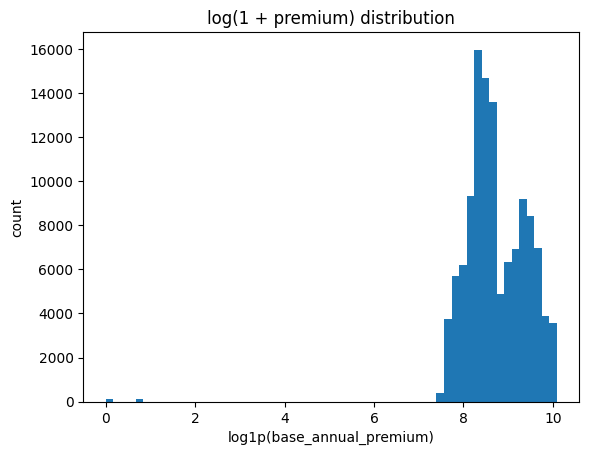

In [37]:
# Premium tail view: log-scale distribution (model friendliness)

plt.figure()
plt.hist(np.log1p(policies["base_annual_premium"]), bins=60)
plt.title("log(1 + premium) distribution")
plt.xlabel("log1p(base_annual_premium)")
plt.ylabel("count")
plt.show()

4. Pricing Context Summary (ready-to-quote)

In [38]:
# Write a concise pricing summary (printable text)

summary = {
    "dataset_version": manifest["dataset_version"],
    "n_policyholders": len(holders),
    "n_policies": len(policies),
    "premium_median": float(policies["base_annual_premium"].median()),
    "premium_mean": float(policies["base_annual_premium"].mean()),
    "tiny_premium_rate": float((policies["base_annual_premium"] <= 1).mean()),
    "top1pct_premium_share": share_at(0.01),
}

print("=== Pricing context summary ===")
for k, v in summary.items():
    if "rate" in k or "share" in k:
        print(f"{k}: {v:.2%}")
    elif "premium" in k:
        print(f"{k}: {v:,.2f}")
    else:
        print(f"{k}: {v}")

=== Pricing context summary ===
dataset_version: v1.0
n_policyholders: 80000
n_policies: 120000
premium_median: 5,556.49
premium_mean: 7,636.26
tiny_premium_rate: 0.20%
top1pct_premium_share: 3.00%


In [39]:
# Premium share + mean premium by product/channel (steering view)
steer = (
    policies.groupby(["product_type", "channel"])
    .agg(
        n=("policy_id", "count"),
        mean_prem=("base_annual_premium", "mean"),
        total_prem=("base_annual_premium", "sum"),
    )
    .reset_index()
)

steer["premium_share"] = steer["total_prem"] / steer["total_prem"].sum()
steer.sort_values("premium_share", ascending=False).head(12)

,product_type,channel,n,mean_prem,total_prem,premium_share
7,home,broker,13213,"13,656.0303","180,437,128.4664",0.1969
10,motor,broker,29666,"5,400.8139","160,220,546.5710",0.1748
4,health,broker,7713,"14,549.2103","112,218,059.2763",0.1225
8,home,direct,7137,"13,663.4642","97,516,143.8320",0.1064
11,motor,direct,16368,"5,403.3920","88,442,719.4413",0.0965
5,health,direct,4365,"14,629.7903","63,859,034.6260",0.0697
6,home,aggregator,3628,"13,594.4763","49,320,759.9709",0.0538
9,motor,aggregator,8124,"5,391.0909","43,797,222.3135",0.0478
3,health,aggregator,2244,"14,527.2144","32,599,069.1827",0.0356
13,warranty,broker,9902,"2,914.3670","28,858,061.5790",0.0315


**Steering view:** Where is premium concentrated by product × channel?

This helps prioritise where pricing effort will matter most, before drilling into loss ratios.

## Pricing implications (what this analysis changes)

Based on the frozen portfolio context:

1. **Prioritise modelling where premium share is largest.**  
   Even “moderate” mispricing on high-premium books has the biggest financial impact.

2. **Expect selection and profitability differences by channel.**  
   Channel often affects outcomes via *loss ratio*, not raw premium level.

3. **Treat coverage as a volatility driver, not just a label.**  
   Coverage mix affects severity tails → capital sensitivity.

4. **The portfolio contains intentional weak risk differentiation.**  
   This creates a controlled “mispricing problem” that we will attempt to recover using actuarial models next.

## Pricing Context Sign-off

✔ Portfolio mix is coherent across product, channel, and coverage dimensions  
✔ Premium distributions are right-skewed with plausible tails  
✔ Structural pricing relativities exist (product, coverage)  
✔ Risk-profile pricing is intentionally flatter, creating modelling opportunity  
✔ Rare premium anomalies exist but do not dominate the book  

**Conclusion:**  
The portfolio is suitable for pricing modelling, segment-level profitability analysis,
and downstream scenario simulation.

## What this enables next (Week 3)

With portfolio mix and premium dispersion established on a frozen dataset, we move to:

- Loss ratio drill-downs by product × channel × risk
- Decomposing profitability into frequency vs severity
- Setting actuarial modelling targets

Next notebook: **03_loss_ratio_drilldown_actuarial_view.ipynb**

**What this analysis does *not* conclude**

- This does not imply current premiums are “wrong”
- This does not recommend immediate repricing actions
- This establishes *context* for controlled modelling experiments on a frozen universe